In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline 

In [25]:
df = pd.read_csv("./data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])

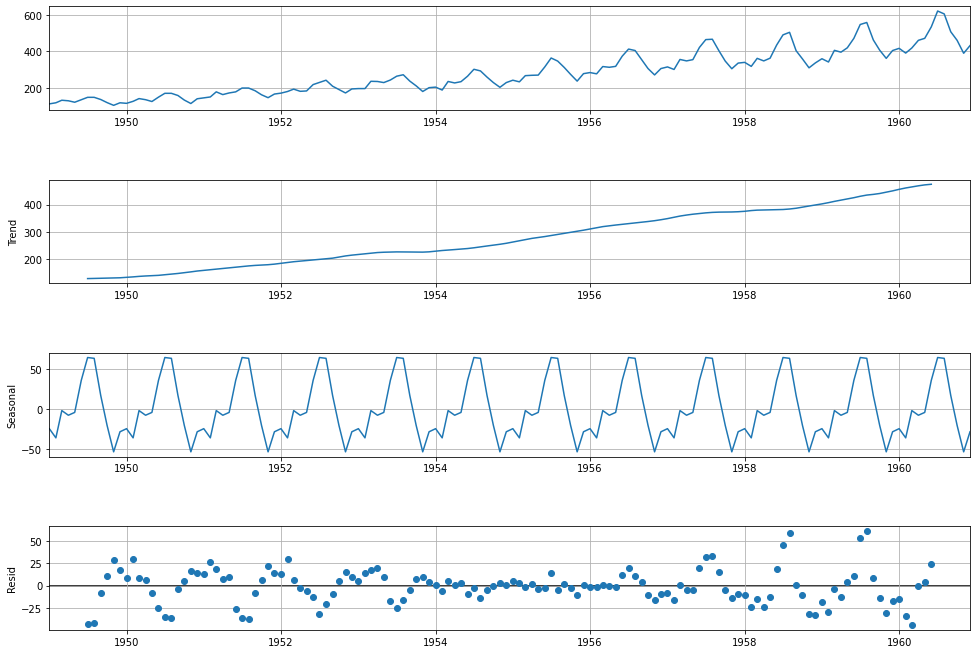

In [26]:
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
fig.set_size_inches(15,10)
# ax = fig.gca()
# ax.grid(True)
ax = fig.get_axes()
[ax[i].grid(True) for i in range(4)]
plt.show()

In [27]:
data = np.array([15, 20, 25, 30, 25, 27])

In [28]:
def exp_smth(x_t_1, a, s_t_1):
	return a*x_t_1+(1-a)*s_t_1
a = 0.7
s = np.zeros(7)
s[0] = data[0]
for t, x_t in enumerate(data):
	s[t+1] = exp_smth(x_t, a, s[t])
print(s)

[15.      15.      18.5     23.05    27.915   25.8745  26.66235]


In [29]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

[26.66235]


C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


## 5. Стационарность
### СТАТИСТИЧЕСКИЕ ТЕСТЫ НА PYTHON

In [30]:
from statsmodels.tsa.stattools import adfuller
df = pd.read_csv('./data/daily-total-female-births.csv', squeeze=True, header=0, index_col=0)
result = adfuller(df.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


#### ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Если тест на стационарность показал, что ряд нестационарный и в нём присутствуют тренд и сезонность, необходимо избавиться от них.

Обычно для этого достаточно взять разность рядов. Разность выполняется путём дифференцирования первого порядка `(periods=1)`. Если полученная первая разность ряда окажется стационарной, то этот ряд называется интегрированным рядом первого порядка.

Для определения порядка интегрированного ряда необходимо сделать следующее:

1. Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):

In [31]:
df_diff_1 = df.diff(periods=1).dropna()

2. Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):

In [32]:
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -12.62517863387136
p-value:  1.5472400091968453e-23
Critical values:  {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
ряд стационарен


### Автокорреляция

автокорреляция — это корреляция ряда с самим собой, сдвинутым во времени, а значит, в формуле автокорреляции вместо  и  будет сам временной ряд и значения этого сдвинутого временного ряда:   

$$r_{1}= \frac {\ sum_{t=2}^{n}(x_t-\bar {x_1}) \cdot (x_{t-1}- \bar{x_2})}{\sqrt {\sum_{t=2}^{n}(x_t- \bar {x_1})^2 \cdot \sum_{t=2}^{n}(x_{t-1}- \bar {x_2})^2}},$$   
где $$\bar{x_1} = \frac{\sum_{t=2}^n x_t}{n-1}; \ \bar{x_2} = \frac{\sum_{t=2}^n x_{t-1}}{n-1}$$.

График автокорреляций разного порядка называется коррелограмма. Его довольно просто построить с помощью метода plot_acf из пакета statsmodels.graphics.tsaplots. Методу необходимо передать всё тот же временной ряд с индексом-датой.

Воспользуемся датасетом из примера сезонной декомпозиции, в котором представлены данные о количестве авиапассажиров в 1949–1960 годах.

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = pd.read_csv("./data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])

Коррелограмма из данного примера выглядит примерно так:

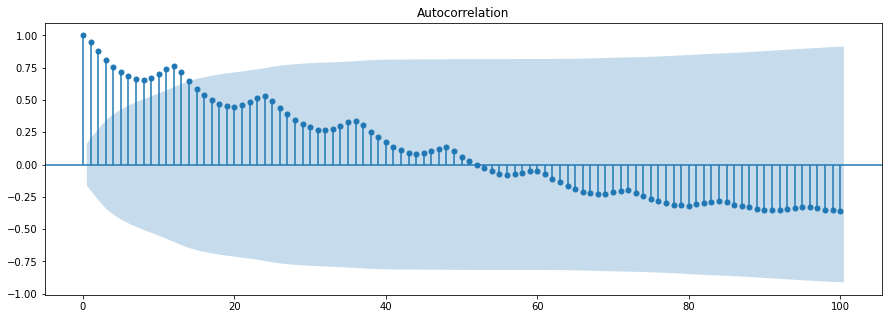

In [34]:
fig = plot_acf(df,lags=100)
fig.set_size_inches(15,5)
plt.show()

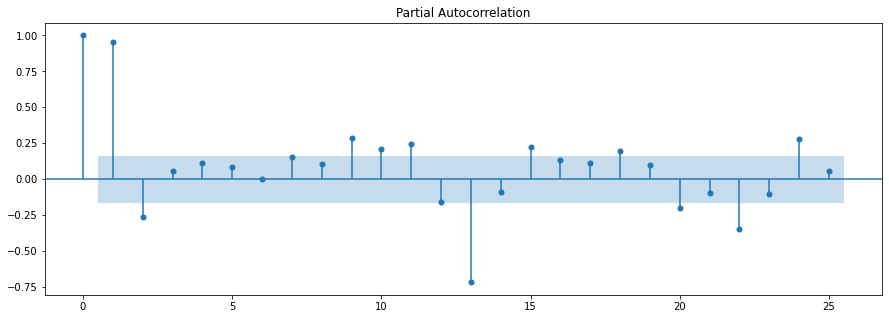

In [35]:
fig = plot_pacf(df,lags=25)
fig.set_size_inches(15,5)
plt.show()

## AR-МОДЕЛИРОВАНИЕ НА PYTHON

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
# statsmodels.tsa.ar_model
# from statsmodels.tsa.ar_model import AR

In [37]:
# url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv('./data/opsd_germany_daily.csv', sep=",")

Признаки в данных:

- Date — дата (в формате гггг-мм-дд);
- Consumption — потребление электроэнергии (ГВтч);
- Wind — производство ветровой энергии (ГВтч);
- Solar — производство солнечной энергии (ГВтч);
- Wind+Solar — сумма производства ветровой и солнечной энергии (ГВтч).   
    
В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).

При использовании статистических моделей временные ряды нельзя делить на обучающую и тестовую выборки случайным образом. Так как нам важно сохранять последовательность, разделим данные на обучающую и тестовую выборки упорядоченно, то есть возьмём в качестве тестовой выборки последние 100 значений. Остальные данные будем использовать для обучения.

In [38]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

Инициализируем и обучим модель. Возьмём lags=8 (AR(8)) — на практике же будем определять это значение по графику частичной автокорреляции:

In [39]:
ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Tue, 27 Dec 2022   AIC                              8.503
Time:                        22:48:34   BIC                              8.518
Sample:                             8   HQIC                             8.509
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Сделаем предсказание. Метод `predict` требует два обязательных параметра — метки начала и окончания предсказания. Метка начала предсказания будет равна количеству данных в обучающей выборке, так как нас интересует прогноз со следующего дня. Метка окончания в нашем случае будет равна `len(train_data)+100`, что эквивалентно `len(df)-1`, так как `len(df) = len(train_data) + len(test_data)`.

In [40]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

4283    1199.580761
4284    1132.051688
4285    1392.772651
4286    1425.877770
4287    1424.606502
           ...     
4378    1355.220188
4379    1359.014426
4380    1334.516355
4381    1299.851112
4382    1309.602440
Length: 100, dtype: float64

###  Итоговая практика

Книжному интернет-магазину необходимо уметь предсказывать объём заказов, чтобы выделить необходимое количество сотрудников на сбор и упаковку и уменьшить задержки. Вам предстоит решить задачу предсказания товарооборота этого магазина.

Датасет состоит из двух столбцов:

- date — дата заказа;
- quantity (qty) — количество книг, заказанных в этот день.

Загрузите датасет и выполните следующие шаги. После вам необходимо будет ответить на вопросы по выполненному заданию.

- Отложите в test последнее значение временного ряда.
- Проанализируйте временной ряд на наличие тренда и сезонности.
- Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (=0.7). - Сравните результат с фактическим значением, которое вы отложили вначале.
- Проверьте ряд на стационарность, определите порядок интегрирования.
- Определите порядок модели AR по графику частичной автокорреляции.
- Постройте модель AR и предскажите последнее значение ряда.    
>Обратите внимание: модель строится на исходном временном ряду.
- Сравните полученные результаты.

In [50]:
data = pd.read_csv('./data/tovar_moving.csv',index_col='date',parse_dates=['date'])

In [55]:
# Отложите в test последнее значение временного ряда.
train = data.iloc[:-1]
test = data.iloc[-1]

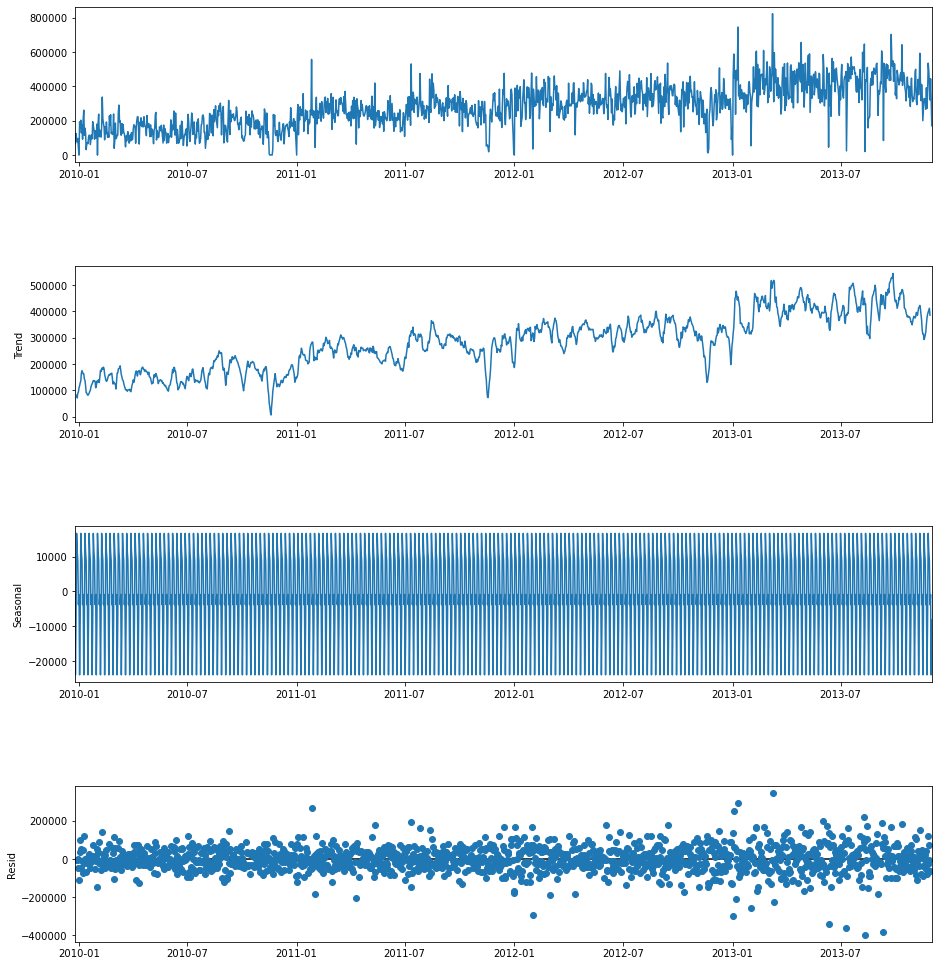

In [107]:
# Проанализируйте временной ряд на наличие тренда и сезонности.
decomposition = seasonal_decompose(train, model='additive') 
fig = decomposition.plot()
fig.set_size_inches(15,15)
# fig.delaxes(fig.get_axes()[0])
plt.show() 

In [110]:
# Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (=0.7). - 
# Сравните результат с фактическим значением, которое вы отложили вначале

In [121]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [122]:
ses = SimpleExpSmoothing(train)
alpha = 0.7

C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [123]:
ses_model = ses.fit(smoothing_level = alpha, optimized = False)

In [125]:
ses_pred = ses_model.forecast(1)
print(f'y_pred: {ses_pred[0]:.1f}    y_true: {test[0]:.1f}') 

y_pred: 225015.5    y_true: 423846.0


In [131]:
# проверьте ряд на стационарность, определите порядок интегрирования
adfuller(train)[1]

0.18678903123416452

In [132]:
train_1diff = train.diff(periods=1).dropna()
adfuller(train_1diff)[1]

9.307227521338382e-26

In [ ]:
# Определите порядок модели AR по графику частичной автокорреляции.

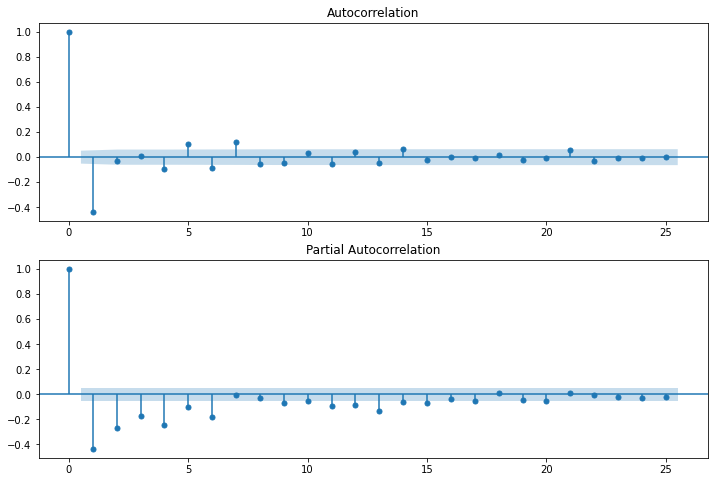

In [153]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_1diff.values.squeeze(), lags=25,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_1diff,lags=25,ax=ax2)

In [143]:
p = 6

In [161]:
# ar_model = AutoReg(train, lags=p).fit()
# print(ar_model.summary())

# ar_pred = ar_model.predict(start=len(train), end=(len(train)), dynamic=False)
# ar_pred

In [163]:
# Постройте модель AR и предскажите последнее значение ряд
аr_model = AutoReg(train, lags=p).fit()
# print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train), end=(len(train)), dynamic=False) #

ar_pred.iloc[0]
print(f'y_pred_ses: {ses_pred[0]:.1f}   y_pred_ar: {ar_pred.iloc[0]:.1f}    y_true: {test[0]:.1f}') 

y_pred_ses: 225015.5   y_pred_ar: 318174.3    y_true: 423846.0


C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
